## CSC 580: Critical Thinking 3 - Predicting Feul Efficiency Using Tensorflow
In a nutshell, this is a *regression* problem where a **neural network** will be created with the ```tf.keras``` API and will utilize the [**Auto MPG**](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset. The trained model will be used to predict the feul efficiency of late 1970s and early 1980s automobiles

In [1]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

#### Data Preparations & Preprocessing

In [2]:
# Download the dataset
data_file = keras.utils.get_file("auto-mpg.data","http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [3]:
# Importing into Pandas
column_names =["MPG","Cylinders","Displacement","Horsepower","Weight","Acceleration","Model Year","Origin"]
raw_data = pd.read_csv(data_file, names=column_names, na_values="?", comment='\t', sep=" ", skipinitialspace=True)
dataset=raw_data.copy()

In [4]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
# Train/test dataset split
train_dataset = dataset.sample(frac=0.8, random_state=0) 
test_dataset = dataset.drop(train_dataset.index)

# Had to include because some missing values made it through. Fixes an issue of getting loss and metrics with 'nan' value
train_dataset.dropna(inplace=True)
test_dataset.dropna(inplace=True)

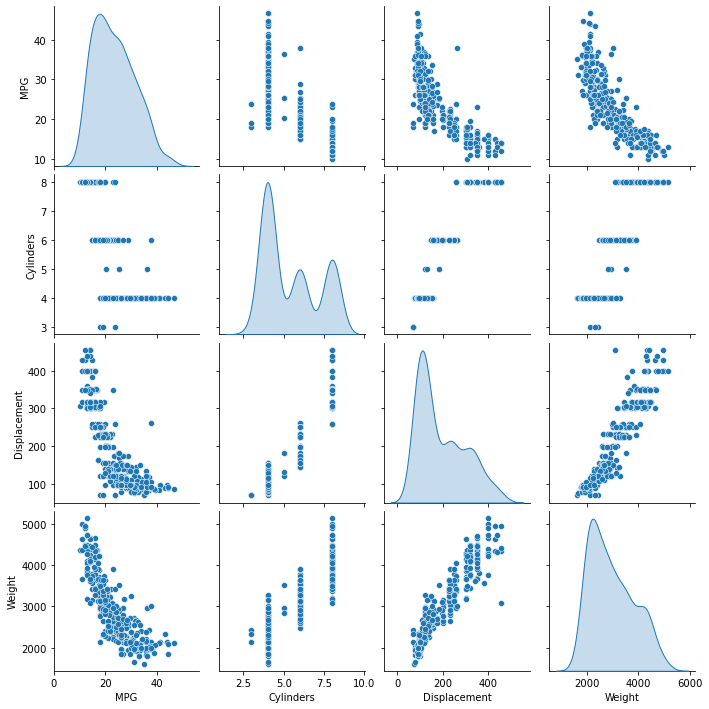

In [6]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [7]:
# Info on training data
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,313.0,5.444089,1.688262,3.0,4.0,4.0,8.0,8.0
Displacement,313.0,193.985623,104.254038,70.0,101.0,151.0,260.0,455.0
Horsepower,313.0,104.067093,38.674662,46.0,75.0,92.0,120.0,230.0
Weight,313.0,2969.731629,848.255781,1613.0,2219.0,2790.0,3609.0,5140.0
Acceleration,313.0,15.573802,2.801033,8.0,13.8,15.5,17.3,24.8
Model Year,313.0,75.891374,3.691773,70.0,73.0,76.0,79.0,82.0
Origin,313.0,1.555911,0.803182,1.0,1.0,1.0,2.0,3.0


In [8]:
# Normalize the data
def norm(x):
    return (x-train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# Separate features and labels
X_train, Y_train = normed_train_data.drop("MPG", axis=1), train_dataset["MPG"]
X_test, Y_test = normed_test_data.drop("MPG", axis=1), test_dataset["MPG"]

#### Constructing the Model

In [9]:
# Model structure was given in assingment parameters
def build_model(loss: str = 'mse'):
    model = keras.Sequential()
    model.add(keras.layers.Input(len(X_train.keys())))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(1))

    optimizer = keras.optimizers.RMSprop(0.001)
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae','mse'])

    return model

In [10]:
model_mse = build_model('mse')
model_mse.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


2022-02-28 14:17:28.965889: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
model_mae = build_model('mae')
model_mae.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Ensuring the model works (Step was required in assignment instructions)
model_mse.predict(X_train[0:10])

2022-02-28 14:17:29.316462: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


array([[-0.39697057],
       [-0.10928085],
       [-0.37416956],
       [-0.32855645],
       [-0.12005979],
       [ 0.20638853],
       [ 0.4902529 ],
       [-0.29769582],
       [-0.25414458],
       [ 0.19722247]], dtype=float32)

#### Training the Model

##### MSE MODEL

In [13]:
# Train the MSE model
EPOCHS = 1000
history = model_mse.fit(X_train, Y_train, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:586.5149,  mae:22.9061,  mse:586.5149,  val_loss:558.3704,  val_mae:22.4684,  val_mse:558.3704,  
....................................................................................................
Epoch: 100, loss:6.8556,  mae:1.8875,  mse:6.8556,  val_loss:5.7736,  val_mae:1.7738,  val_mse:5.7736,  
....................................................................................................
Epoch: 200, loss:5.8670,  mae:1.7209,  mse:5.8670,  val_loss:5.5441,  val_mae:1.7148,  val_mse:5.5441,  
....................................................................................................
Epoch: 300, loss:5.1701,  mae:1.6047,  mse:5.1701,  val_loss:6.8876,  val_mae:1.8188,  val_mse:6.8876,  
....................................................................................................
Epoch: 400, loss:4.7547,  mae:1.5222,  mse:4.7547,  val_loss:5.3044,  val_mae:1.6199,  val_mse:5.3044,  
..............................................................

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.716697,1.075041,2.716697,6.055721,1.710604,6.055721,995
996,2.575836,1.042292,2.575836,5.878383,1.685189,5.878383,996
997,2.714668,1.076580,2.714668,5.610993,1.648303,5.610993,997
998,2.572270,1.076036,2.572270,5.759574,1.716497,5.759574,998
999,2.848337,1.108202,2.848337,5.640687,1.654897,5.640687,999


In [15]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

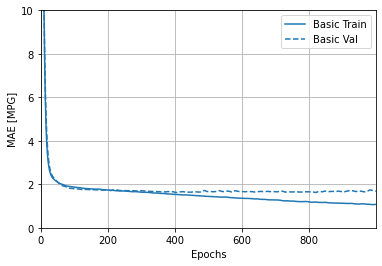

In [16]:
plotter.plot({'Basic': history}, metric = "mae")  
plt.ylim([0, 10])  
plt.ylabel('MAE [MPG]')    

Text(0, 0.5, 'MSE [MPG^2]')

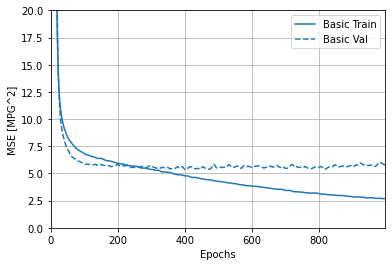

In [17]:
plotter.plot({'Basic': history}, metric = "mse")  
plt.ylim([0, 20])  
plt.ylabel('MSE [MPG^2]')    

##### MAE MODEL

In [18]:
# Train the MSE model
EPOCHS = 1000
history = model_mae.fit(X_train, Y_train, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:22.6350,  mae:22.6350,  mse:576.4805,  val_loss:22.1825,  val_mae:22.1825,  val_mse:548.8296,  
....................................................................................................
Epoch: 100, loss:1.8187,  mae:1.8187,  mse:8.0244,  val_loss:2.0043,  val_mae:2.0043,  val_mse:6.7858,  
....................................................................................................
Epoch: 200, loss:1.6787,  mae:1.6787,  mse:7.1436,  val_loss:1.8651,  val_mae:1.8651,  val_mse:6.2082,  
....................................................................................................
Epoch: 300, loss:1.6014,  mae:1.6014,  mse:6.8631,  val_loss:1.8120,  val_mae:1.8120,  val_mse:6.1275,  
....................................................................................................
Epoch: 400, loss:1.5144,  mae:1.5144,  mse:6.1922,  val_loss:1.7701,  val_mae:1.7701,  val_mse:6.0289,  
................................................................

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,1.266522,1.266522,5.170171,1.665807,1.665807,5.783890,995
996,1.249876,1.249876,4.929243,1.634654,1.634654,5.638654,996
997,1.258068,1.258068,5.010839,1.639665,1.639665,5.715891,997
998,1.263868,1.263868,5.184589,1.680389,1.680389,5.779274,998
999,1.245948,1.245948,5.054429,1.827124,1.827124,6.440623,999


Text(0, 0.5, 'MAE [MPG]')

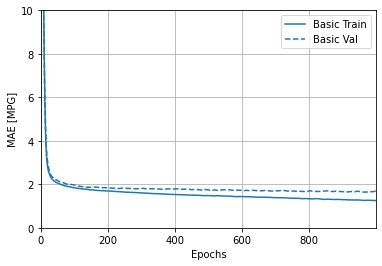

In [20]:
plotter.plot({'Basic': history}, metric = "mae")  
plt.ylim([0, 10])  
plt.ylabel('MAE [MPG]')  

Text(0, 0.5, 'MSE [MPG^2]')

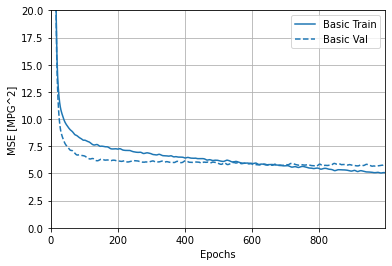

In [21]:
plotter.plot({'Basic': history}, metric = "mse")  
plt.ylim([0, 20])  
plt.ylabel('MSE [MPG^2]')    